# 09. Aggregated HDBSCAN Clustering

HDBSCAN clustering at three aggregation levels:
1. **Buyers** - cluster buyers by procurement behavior patterns
2. **Suppliers** - cluster suppliers by winning patterns (detect cartels)
3. **Buyer-Supplier Pairs** - cluster relationships (detect collusion)

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.data_loader import load_tenders, load_buyers, load_suppliers
from src.detectors import AggregatedHDBSCAN

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-02-07 19:40:56


## 1. Load Data

In [2]:
tenders = load_tenders(years=[2022, 2023, 2024, 2025])
buyers = load_buyers()
suppliers = load_suppliers()

print(f"Tenders: {len(tenders):,}")
print(f"Buyers: {len(buyers):,}")
print(f"Suppliers: {len(suppliers):,}")

Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Loaded buyers: 35,995
Loaded suppliers: 358,376
Tenders: 12,877,960
Buyers: 35,995
Suppliers: 358,376


## 2. Initialize Detector

In [3]:
detector = AggregatedHDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    metric="euclidean",
)

## 3. Cluster Buyers

Find groups of buyers with similar procurement patterns. Outliers = suspicious buyers.

In [4]:
buyer_results = detector.cluster_buyers(tenders, buyers)

Clustering BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'total_value']
  Buyers: 35,995
  Clusters: 440
  Noise (outliers): 19,105 (53.1%)
  Anomalies (top 5%): 19,193 (53.3%)


In [5]:
print("\nBuyer clustering results:")
print(f"  Total buyers: {len(buyer_results):,}")
print(f"  Clusters: {buyer_results['cluster'].nunique() - 1}")
print(f"  Noise (outliers): {buyer_results['is_noise'].sum():,}")
print(f"  Anomalies: {buyer_results['is_anomaly'].sum():,}")


Buyer clustering results:
  Total buyers: 35,995
  Clusters: 440
  Noise (outliers): 19,105
  Anomalies: 19,193


In [6]:
# Suspicious buyers (high outlier score)
suspicious_buyers = detector.get_suspicious_buyers(min_score=0.5)
print(f"\nSuspicious buyers (score >= 0.5): {len(suspicious_buyers):,}")

if len(suspicious_buyers) > 0:
    print("\nTop 10 by outlier score:")
    display(suspicious_buyers.nlargest(10, 'outlier_score'))


Suspicious buyers (score >= 0.5): 19,654

Top 10 by outlier score:


,buyer_id,cluster,probability,outlier_score,is_noise,is_anomaly,single_bidder_rate,competitive_rate,avg_discount_pct,supplier_diversity_index,total_tenders,total_value
0,40295882,-1,0.0,1.0,1,1,0.000334,0.000788,0.042697,0.016495,64226,3.201191e+09
1,38357766,-1,0.0,1.0,1,1,0.001007,0.003526,0.117540,0.073036,34945,2.950025e+08
2,39776588,-1,0.0,1.0,1,1,0.001285,0.001820,0.048113,0.103330,14186,2.832284e+08
3,41076819,-1,0.0,1.0,1,1,0.000161,0.000000,0.000515,0.071337,13377,2.187065e+08
4,38313100,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,12330,3.961513e+07
5,38351628,-1,0.0,1.0,1,1,0.000246,0.003197,0.075250,0.130841,10927,1.745288e+08
6,03767831,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,10052,2.614186e+09
7,21560045,-1,0.0,1.0,1,1,0.160263,0.240647,6.656740,0.452477,9972,1.779480e+10
8,38324552,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,9708,2.906917e+07
9,19122935,-1,0.0,1.0,1,1,0.005405,0.015135,0.328641,0.033153,9699,9.233682e+07


In [7]:
# Compare suspicious vs normal buyers
if len(suspicious_buyers) > 0 and 'single_bidder_rate' in buyer_results.columns:
    normal_buyers = buyer_results[buyer_results['outlier_score'] < 0.5]
    
    print("Comparison: Suspicious vs Normal Buyers")
    print("="*50)
    
    for col in ['single_bidder_rate', 'competitive_rate', 'total_value']:
        if col in buyer_results.columns:
            sus_mean = suspicious_buyers[col].mean()
            norm_mean = normal_buyers[col].mean()
            print(f"{col}:")
            print(f"  Suspicious: {sus_mean:.3f}")
            print(f"  Normal:     {norm_mean:.3f}")

Comparison: Suspicious vs Normal Buyers
single_bidder_rate:
  Suspicious: 0.053
  Normal:     0.013
competitive_rate:
  Suspicious: 0.051
  Normal:     0.016
total_value:
  Suspicious: 172465013.332
  Normal:     26270667.744


## 4. Cluster Suppliers

Find groups of suppliers with similar winning patterns. Outliers = potential cartel members or anomalous suppliers.

In [8]:
supplier_results = detector.cluster_suppliers(tenders, suppliers)

Clustering SUPPLIERS...
  Computing supplier features from tenders (Polars)...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377
  Clusters: 9522
  Noise (outliers): 101,914 (28.4%)
  Anomalies (top 5%): 119,167 (33.3%)


In [9]:
print("\nSupplier clustering results:")
print(f"  Total suppliers: {len(supplier_results):,}")
print(f"  Clusters: {supplier_results['cluster'].nunique() - 1}")
print(f"  Noise (outliers): {supplier_results['is_noise'].sum():,}")
print(f"  Anomalies: {supplier_results['is_anomaly'].sum():,}")


Supplier clustering results:
  Total suppliers: 358,377
  Clusters: 9522
  Noise (outliers): 101,914
  Anomalies: 119,167


In [10]:
# Suspicious suppliers
suspicious_suppliers = detector.get_suspicious_suppliers(min_score=0.5)
print(f"\nSuspicious suppliers (score >= 0.5): {len(suspicious_suppliers):,}")

if len(suspicious_suppliers) > 0:
    print("\nTop 10 by outlier score:")
    display(suspicious_suppliers.nlargest(10, 'outlier_score'))


Suspicious suppliers (score >= 0.5): 127,974

Top 10 by outlier score:


,supplier_id,cluster,probability,outlier_score,is_noise,is_anomaly,total_awards,total_value,avg_award_value,buyer_count,single_bidder_rate,avg_competitors
4,2490114799,-1,0.0,1.0,1,1,2,1.204000e+04,6020.000000,2,0.000000,0.000000
11,37123596/371235913502,977,0.0,1.0,0,1,1,1.926000e+03,1926.000000,1,0.000000,0.000000
14,3228219310,-1,0.0,1.0,1,1,10,6.484183e+05,64841.826000,2,0.000000,0.000000
15,40628724,-1,0.0,1.0,1,1,22,3.828700e+06,174031.818182,5,0.000000,0.000000
16,2277118533,1657,0.0,1.0,0,1,1,1.210800e+03,1210.800000,1,0.000000,0.000000
17,21738610,-1,0.0,1.0,1,1,6234,1.079654e+09,173188.047132,552,0.123516,0.669394
29,41644024,-1,0.0,1.0,1,1,1,1.742780e+05,174278.020000,1,0.000000,0.000000
34,2513016498,-1,0.0,1.0,1,1,18,1.418951e+06,78830.607778,4,0.000000,0.000000
39,2605001877,-1,0.0,1.0,1,1,1,1.207800e+04,12078.000000,1,0.000000,0.000000
40,43669234,-1,0.0,1.0,1,1,67,1.200356e+06,17915.757761,25,0.044776,0.044776


In [11]:
# Supplier clusters analysis
print("\nSupplier Cluster Analysis:")
print("="*50)

cluster_stats = supplier_results.groupby('cluster').agg({
    'supplier_id': 'count',
    'total_awards': 'mean',
    'total_value': 'mean',
    'single_bidder_rate': 'mean',
}).round(2)
cluster_stats.columns = ['count', 'avg_awards', 'avg_value', 'single_bidder_rate']
cluster_stats = cluster_stats.sort_values('count', ascending=False)

display(cluster_stats.head(10))


Supplier Cluster Analysis:


,count,avg_awards,avg_value,single_bidder_rate
cluster,,,,
-1,101914,97.73,35838426.58,0.09
9201,3041,46.31,668089.70,0.00
9226,2251,40.06,636486.12,0.00
9309,1643,53.61,762978.79,0.00
3247,1003,1.00,10000.00,0.00
9337,947,51.42,722074.54,0.00
3252,886,1.00,5000.00,0.00
3344,818,1.00,20000.00,0.00
2767,805,1.00,14999.99,0.00


## 5. Cluster Buyer-Supplier Pairs

Find groups of relationships with similar patterns. Outliers = suspicious collusive relationships.

In [12]:
pair_results = detector.cluster_pairs(tenders, min_contracts=3)

Clustering BUYER-SUPPLIER PAIRS...
  Computing pair features from tenders (Polars)...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']
  Clusters: 7912
  Noise (outliers): 607,293 (66.3%)
  Anomalies (top 5%): 607,317 (66.3%)


In [13]:
if len(pair_results) > 0:
    print("\nBuyer-Supplier pair clustering results:")
    print(f"  Total pairs: {len(pair_results):,}")
    print(f"  Clusters: {pair_results['cluster'].nunique() - 1}")
    print(f"  Noise (outliers): {pair_results['is_noise'].sum():,}")
    print(f"  Anomalies: {pair_results['is_anomaly'].sum():,}")


Buyer-Supplier pair clustering results:
  Total pairs: 916,278
  Clusters: 7912
  Noise (outliers): 607,293
  Anomalies: 607,317


In [14]:
# Suspicious pairs (potential collusion)
if len(pair_results) > 0:
    suspicious_pairs = detector.get_suspicious_pairs(min_score=0.5)
    print(f"\nSuspicious pairs (score >= 0.5): {len(suspicious_pairs):,}")

    if len(suspicious_pairs) > 0:
        print("\nTop 10 suspicious pairs by outlier score:")
        display(suspicious_pairs.nlargest(10, 'outlier_score')[[
            'buyer_id', 'supplier_id', 'outlier_score', 
            'contracts_count', 'total_value', 'single_bidder_rate',
            'exclusivity_buyer', 'exclusivity_supplier'
        ]])


Suspicious pairs (score >= 0.5): 607,881

Top 10 suspicious pairs by outlier score:


,buyer_id,supplier_id,outlier_score,contracts_count,total_value,single_bidder_rate,exclusivity_buyer,exclusivity_supplier
1,44539336,03339176,1.0,3,26082.00,0.0,0.002865,0.005263
2,01991754,44467941,1.0,3,673410.00,0.0,0.001608,0.003359
4,01204408,2544204705,1.0,8,96402.50,0.0,0.007313,0.123077
5,02005255,38200828,1.0,3,7549.28,0.0,0.027523,0.081081
9,01998265,2900202794,1.0,15,134917.35,0.0,0.011253,0.033333
10,38460215,44456458,1.0,7,53260.68,0.0,0.022222,0.140000
11,23068236,2384806215,1.0,13,20586.00,0.0,0.094891,0.076923
12,03772660,01982726,1.0,3,57557.65,0.0,0.003151,0.049180
13,38296363,40108947,1.0,4,493200.00,0.0,0.008696,0.003929
17,14035769,2881605099,1.0,4,5340.00,0.0,0.006861,0.006299


In [15]:
# Highly exclusive relationships (potential red flags)
if len(pair_results) > 0:
    exclusive_pairs = pair_results[
        (pair_results['exclusivity_buyer'] > 0.5) | 
        (pair_results['exclusivity_supplier'] > 0.5)
    ]
    print(f"\nHighly exclusive relationships (>50% exclusivity): {len(exclusive_pairs):,}")
    
    if len(exclusive_pairs) > 0:
        print("\nTop 10 by buyer exclusivity:")
        display(exclusive_pairs.nlargest(10, 'exclusivity_buyer')[[
            'buyer_id', 'supplier_id', 'contracts_count', 'total_value',
            'exclusivity_buyer', 'exclusivity_supplier', 'single_bidder_rate'
        ]])


Highly exclusive relationships (>50% exclusivity): 92,216

Top 10 by buyer exclusivity:


,buyer_id,supplier_id,contracts_count,total_value,exclusivity_buyer,exclusivity_supplier,single_bidder_rate
2301,45075364,2211100603,3,10600.00,1.0,0.003559,0.0
14712,36658119,42082379,3,220488.92,1.0,0.000517,0.0
22181,44148860,3206214882,3,37287.00,1.0,0.040541,0.0
31024,43255926,44314547,4,896484.00,1.0,0.030075,0.0
37645,38428391,39640167,3,499791.88,1.0,0.009404,0.0
44106,41361662,2712713895,3,177000.00,1.0,0.004680,0.0
55220,43967232,32168763,3,170770.00,1.0,0.003947,0.0
64033,26291408,2556506860,7,39312.00,1.0,0.086420,0.0
66074,00689384,19389532,3,87028.00,1.0,1.000000,0.0
70915,45725630,2917900234,4,18549.00,1.0,0.006623,0.0


## 6. Summary

In [16]:
summaries = detector.summary()

for level, summary_df in summaries.items():
    print(f"\n{level.upper()} Summary:")
    print("="*40)
    display(summary_df)


BUYERS Summary:


,metric,value
0,total,35995.000000
1,clusters,441.000000
2,noise,19105.000000
3,noise_pct,53.076816
4,anomalies,19193.000000
5,anomaly_pct,53.321295



SUPPLIERS Summary:


,metric,value
0,total,358377.000000
1,clusters,9523.000000
2,noise,101914.000000
3,noise_pct,28.437651
4,anomalies,119167.000000
5,anomaly_pct,33.251855



PAIRS Summary:


,metric,value
0,total,916278.000000
1,clusters,7913.000000
2,noise,607293.000000
3,noise_pct,66.278247
4,anomalies,607317.000000
5,anomaly_pct,66.280867


## 7. Visualizations

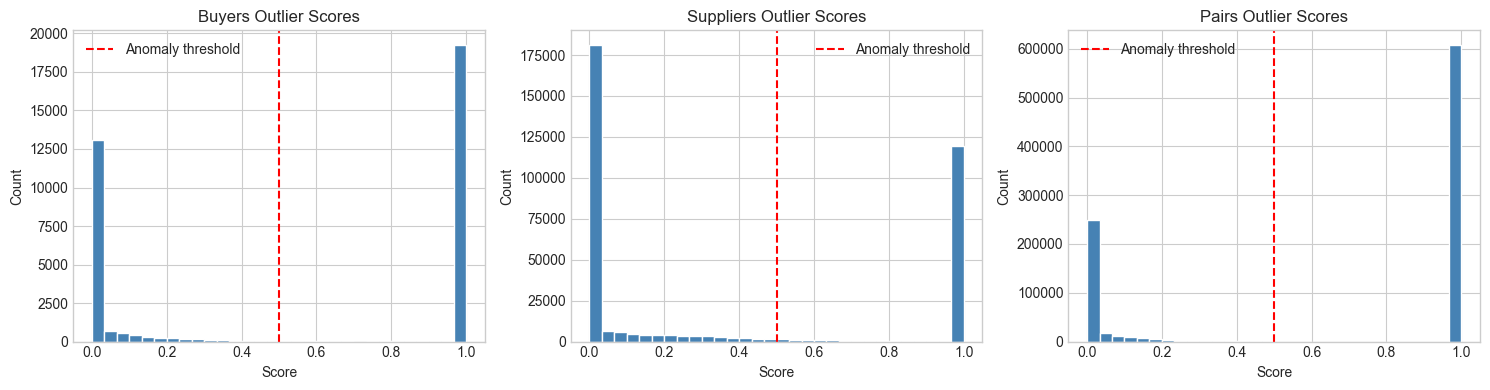

In [17]:
# Outlier score distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, results) in zip(axes, [
    ('Buyers', detector.buyer_results_),
    ('Suppliers', detector.supplier_results_),
    ('Pairs', detector.pair_results_),
]):
    if results is not None and len(results) > 0:
        results['outlier_score'].hist(bins=30, ax=ax, color='steelblue', edgecolor='white')
        ax.axvline(x=0.5, color='red', linestyle='--', label='Anomaly threshold')
        ax.set_title(f'{name} Outlier Scores')
        ax.set_xlabel('Score')
        ax.set_ylabel('Count')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{name} Outlier Scores')

plt.tight_layout()
plt.savefig('../results/aggregated_hdbscan_scores.png', dpi=150, bbox_inches='tight')
plt.show()

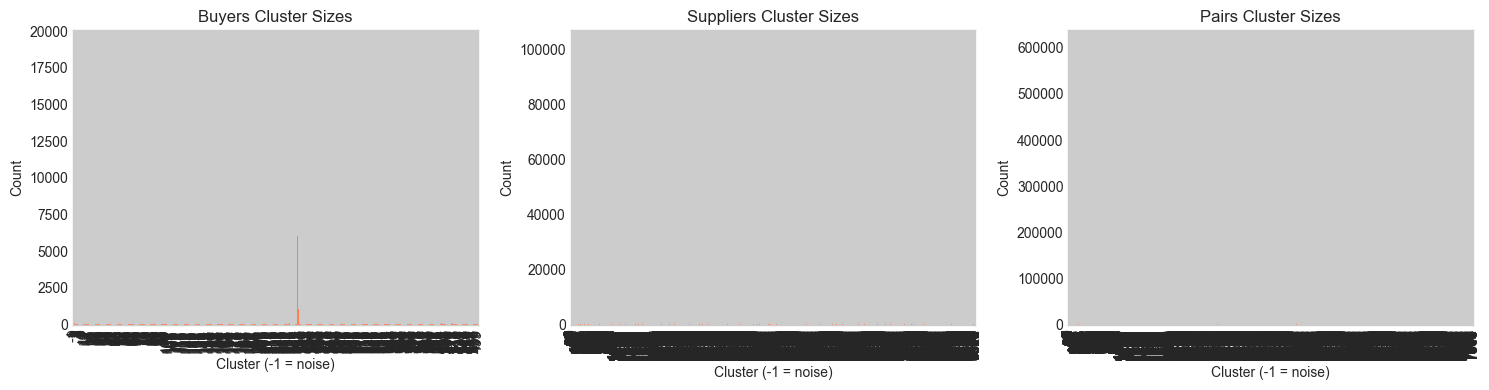

In [18]:
# Cluster sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, results) in zip(axes, [
    ('Buyers', detector.buyer_results_),
    ('Suppliers', detector.supplier_results_),
    ('Pairs', detector.pair_results_),
]):
    if results is not None and len(results) > 0:
        cluster_sizes = results['cluster'].value_counts().sort_index()
        cluster_sizes.plot(kind='bar', ax=ax, color='coral')
        ax.set_title(f'{name} Cluster Sizes')
        ax.set_xlabel('Cluster (-1 = noise)')
        ax.set_ylabel('Count')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{name} Cluster Sizes')

plt.tight_layout()
plt.savefig('../results/aggregated_hdbscan_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Results

In [19]:
# Save anomalies from each level
if detector.buyer_results_ is not None:
    suspicious_buyers = detector.get_suspicious_buyers(0.5)
    suspicious_buyers.to_csv('../results/hdbscan_suspicious_buyers.csv', index=False)
    print(f"Saved {len(suspicious_buyers)} suspicious buyers")

if detector.supplier_results_ is not None:
    suspicious_suppliers = detector.get_suspicious_suppliers(0.5)
    suspicious_suppliers.to_csv('../results/hdbscan_suspicious_suppliers.csv', index=False)
    print(f"Saved {len(suspicious_suppliers)} suspicious suppliers")

if detector.pair_results_ is not None and len(detector.pair_results_) > 0:
    suspicious_pairs = detector.get_suspicious_pairs(0.5)
    suspicious_pairs.to_csv('../results/hdbscan_suspicious_pairs.csv', index=False)
    print(f"Saved {len(suspicious_pairs)} suspicious pairs")

print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Saved 19654 suspicious buyers
Saved 127974 suspicious suppliers
Saved 607881 suspicious pairs

Completed: 2026-02-07 19:46:16
